# Heart Disease Predictor 

In [24]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

## Loading Data

In [3]:
df = pd.read_csv('./heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [5]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

## Data Cleaning

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.shape

(301717, 18)

In [10]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [11]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,301717.000000,301717.000000,301717.000000,301717.000000
mean,28.441970,3.572298,4.121475,7.084559
std,6.468134,8.140656,8.128288,1.467122
min,12.020000,0.000000,0.000000,1.000000
25%,24.030000,0.000000,0.000000,6.000000
50%,27.410000,0.000000,0.000000,7.000000
75%,31.650000,2.000000,4.000000,8.000000
max,94.850000,30.000000,30.000000,24.000000


## Understanding the data

In [22]:
count_target = df['HeartDisease'].value_counts()
count_target

HeartDisease
No     274456
Yes     27261
Name: count, dtype: int64

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(x=count_target.index,y=count_target.values,data=df)
plt.title('Distribution of Heart Disease')
plt.xlabel('Heary Disease')
plt.ylabel('Count')
plt.show()

ValueError: Length of Index vectors must match length of `data` when both are used, but `data` has length 301717 and the vector passed to `x` has length 2.

<Figure size 1000x600 with 0 Axes>

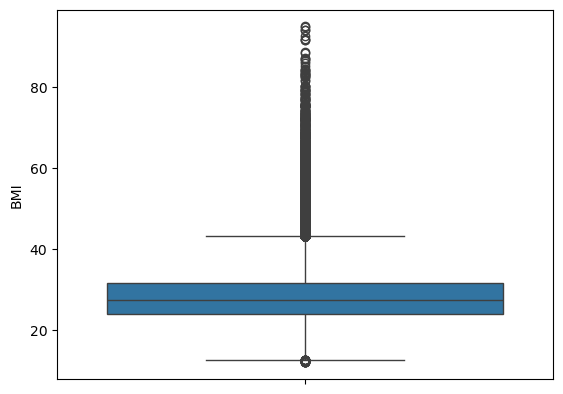

In [21]:
sns.boxplot(df['BMI'])
plt.show()